In [15]:
import opendatasets as od
import random
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
od.download("https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews")

Skipping, found downloaded files in ".\trip-advisor-hotel-reviews" (use force=True to force download)


## Load dataset

In [3]:
df_reviews = pd.read_csv("trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv", encoding='latin')

## Dataset exploration

In [4]:
df_reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
df_reviews.tail()

,Review,Rating
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


In [6]:
df_reviews.isnull().sum()

Review    0
Rating    0
dtype: int64

In [7]:
df_reviews.Rating.unique()

array([4, 2, 3, 5, 1], dtype=int64)

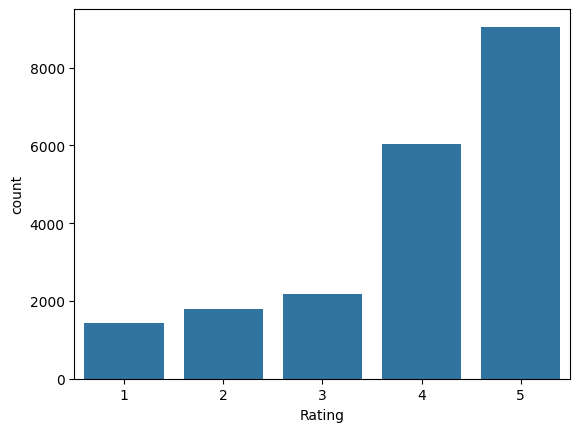

In [8]:
sns.countplot(x=df_reviews.Rating);

In [9]:
## Dividing the 5 rating values between 4 or more and 3 or less
df_reviews['Rating'] = np.where(df_reviews['Rating']<=4, 1,0)

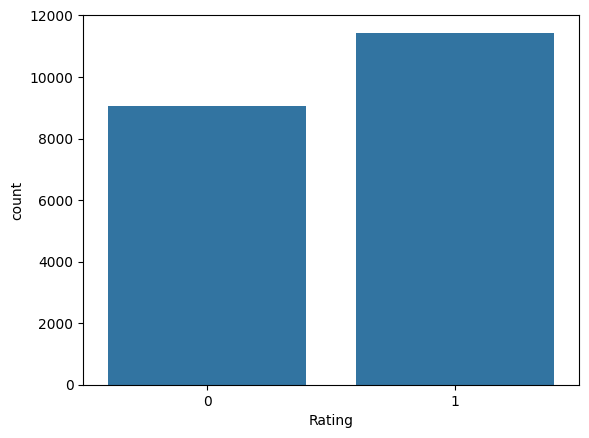

In [10]:
sns.countplot(x=df_reviews.Rating);

## Cleaning data and preprocessing text (removing unnecessary punctuation, numbers , stopwords, other tags and lowering the text)

In [11]:
corpus = []
for i in range(len(df_reviews)):
    review = re.sub('^a-zA-Z', ' ', df_reviews['Review'][i])
    review = re.sub('[\d-]', ' ', df_reviews['Review'][i])
    review = review.lower()
    review = review.split()
    [word for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

## Splitting data into training and test

In [12]:
X = np.array(corpus)
y = df_reviews['Rating'].to_numpy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, stratify=y)

## Creation of a Pipeline for MultinomialNaiveBayes classifier model with TF-IDF Vectorizer

In [16]:
naive_bayes_model = Pipeline([('tfidf',TfidfVectorizer()),
                              ('clf',MultinomialNB())])

In [17]:
naive_bayes_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
naive_bayes_model.score(X_test, y_test)

0.7199316906562576

## Creation of a Pipeline for RandomForest classifier model with TF-IDF Vectorizer

In [19]:
rf_model = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',RandomForestClassifier())])

In [20]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [21]:
rf_model.score(X_test, y_test)

0.7521346669919493

## Creation of a Pipeline for XGBoost model with TF-IDF Vectorizer

In [22]:
xgb_model = Pipeline([('tfidf',TfidfVectorizer()),
                      ('clf',xgb.XGBRFClassifier())])

In [23]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 device=None, early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=None,
                                 n_jobs=None, num_parallel_tree=None,
                                 objective='binary:logistic', random_state=None,
                                 reg_alpha=None, ...))])

In [24]:
xgb_model.score(X_test, y_test)

0.6887045620883142

# Plotting all models results

In [25]:
def model_results(y_test, y_pred):
    precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_pred)
    return {'precision':np.mean(precision),'recall':np.mean(recall),'f1':np.mean(f1)}

In [26]:
## Predicitions from MultinomialNB model
naive_bayes_preds = naive_bayes_model.predict(X_test)
##Predictions from RandomForest model
rf_preds = rf_model.predict(X_test)
##Predictions from XGBoost model
xgb_preds = xgb_model.predict(X_test)

In [27]:
naive_bayes_results = model_results(y_test, naive_bayes_preds)
rf_results = model_results(y_test, rf_preds)
xgb_results = model_results(y_test, xgb_preds)

In [29]:
df_results=pd.DataFrame({'NaiveBayes':naive_bayes_results,
                         'RandomForestClassifier':rf_results,
                         'XGB':xgb_results}).transpose()

In [30]:
df_results

,precision,recall,f1
NaiveBayes,0.747764,0.695078,0.693342
RandomForestClassifier,0.751886,0.742228,0.744623
XGB,0.685844,0.676430,0.677773


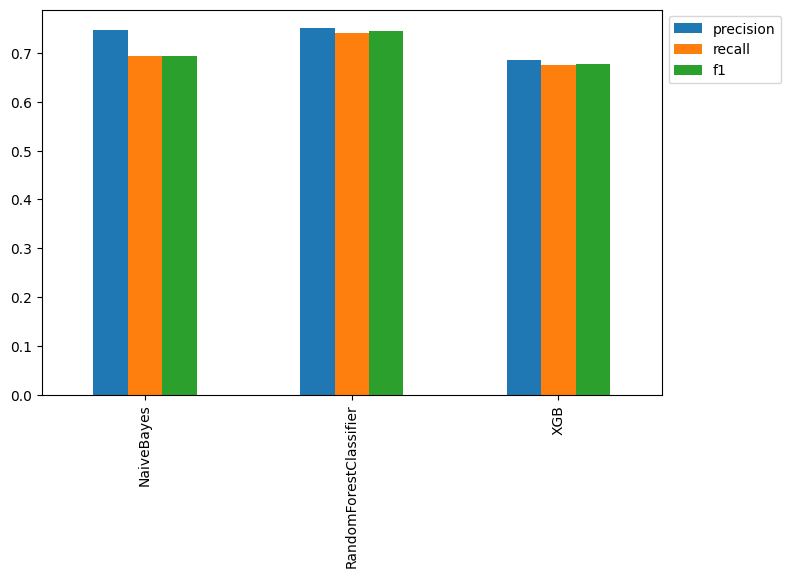

In [33]:
#Plot and compare all of the model results
df_results.plot(kind='bar', figsize=(8,5)).legend(bbox_to_anchor=(1.,1.));